In [2]:
# Import python libraries
#
import importlib
import pickle
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Go one directory back, because all imports are done
# relative to the root of the project.
#
project_root = '..'
if 'change_directory_to_root' not in globals():
    change_directory_to_root = True
    os.chdir(project_root)

# Imports own modules.
#
import scripts.Visualization as Visualization
import scripts.ModelTrainer as ModelTrainer
import scripts.Utils as utils
import scripts.Simulation_config as Simulation_config
from scripts.Simulation_config import *
import scripts.Model as Model
import scripts.ModelAdapter as ModelAdapter


/home/molu/miniconda3/envs/xlstm/lib/python3.11/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987288773/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
No CUDA runtime is found, using CUDA_HOME='/home/molu/miniconda3/envs/xlstm'


In [2]:
# Store specific predictions, for the paper 'use case' section.
#
execute_this_cell = True
if execute_this_cell:
    importlib.reload(Model)
    importlib.reload(Simulation_config)
    importlib.reload(utils)
    importlib.reload(ModelTrainer)

    # Get specific results
    #
    result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                        print_style = 'pandas_df')

    # Define a specific configuration
    #
    myConfig = Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
                    NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT)

    modelTrainer = ModelTrainer.ModelTrainer()
    loadProfiles, weatherData, public_holidays_timestamps = modelTrainer.load_data(myConfig)
    modelAdapter = ModelAdapter.ModelAdapter(public_holidays_timestamps, 
                                                train_size = myConfig.trainingHistory,
                                                test_size = modelTrainer.test_set_size_days, 
                                                prediction_history = myConfig.modelInputHistory,
                                                )
    community_id = 0  # chose one of many energy communites
    X, Y = modelAdapter.transformData(loadProfiles[community_id], weatherData)
    path_to_trained_parameters = 'scripts/outputs/all_trained_models.pth'
    num_of_features = X['train'].shape[2]
    P_el_predicted = modelAdapter.deNormalizeY(Y['test']).flatten().unsqueeze(0)

    # Store the predicted power profiles
    #
    for model_type in Simulation_config.UsedModels.ALL:
        test_profile = f"scripts/outputs/file_{community_id}.pkl"
        my_Model = utils.Deserialize.get_trained_model(path_to_trained_parameters, model_type, test_profile, myConfig, num_of_features)
        Y_pred = torch.Tensor(modelAdapter.deNormalizeY(my_Model.predict(X['test'], Y['test'])).flatten())
        P_el_predicted = torch.cat([P_el_predicted, Y_pred.unsqueeze(0)], dim=0)    

    startdate = modelAdapter.getStartDateFromIndex('test', 0)
    timestamp = utils.Serialize.get_act_timestamp()
    file_path = f"scripts/outputs/example_predictions{timestamp}.pkl"
    with open(file_path, 'wb') as file:
        pickle.dump((P_el_predicted, startdate), file)

    print(P_el_predicted.shape)
    print(startdate)


torch.Size([7, 3144])
2013-10-20 00:00:00+00:00


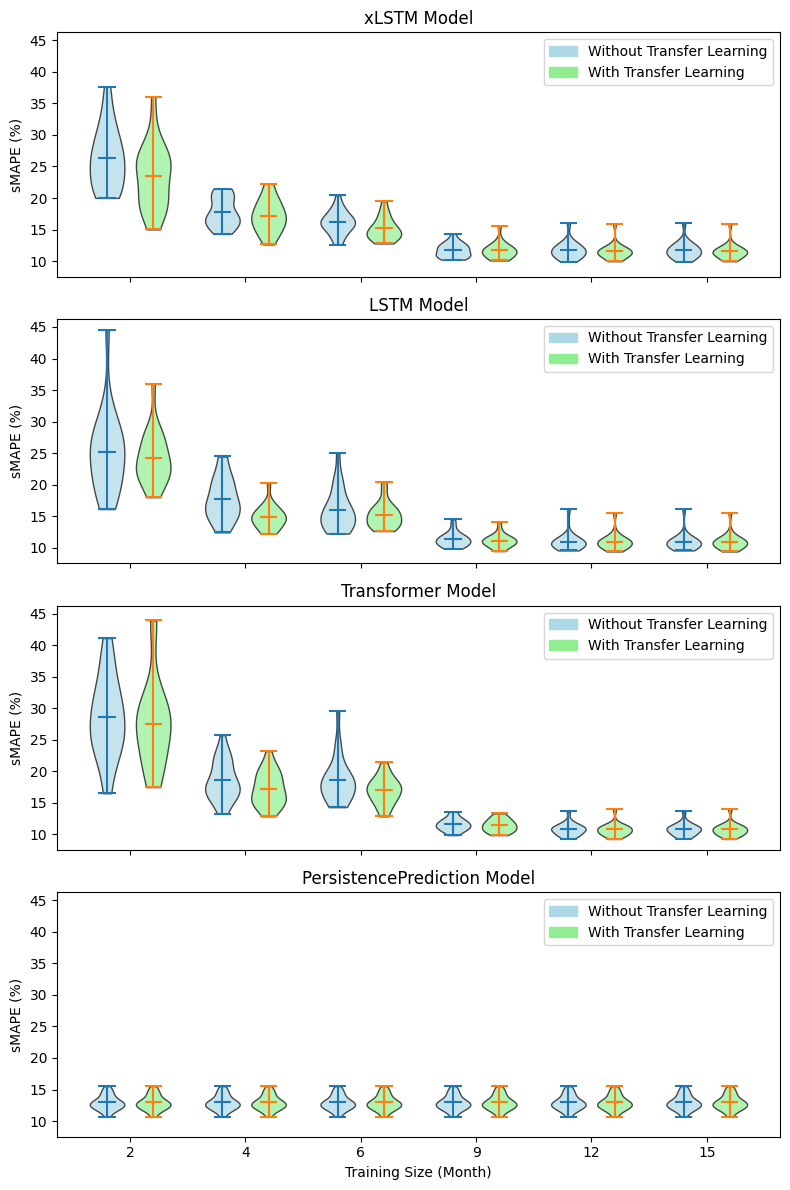

In [20]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT), 
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),       
    
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._2_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._4_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._6_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._9_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),  
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, 
            NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
]

# Constants and Configuration
models = ['xLSTM', 'LSTM', 'Transformer', 'PersistencePrediction']
configs_with_transfer = configs[0:6]
configs_without_transfer = configs[6:12]
training_sizes = ['2', '4', '6', '9', '12', '15']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model and transfer condition
data_with_transfer = {model: get_full_data_list(model, configs_with_transfer, result_dict) for model in models}
data_without_transfer = {model: get_full_data_list(model, configs_without_transfer, result_dict) for model in models}

# Creating subplots for violin plots
fig, axes = plt.subplots(len(models), 1, figsize=(8, 12), sharex=True, sharey=True)

# Define legend patches for the legend
legend_patches = [
    Patch(color="lightblue", label="Without Transfer Learning"),
    Patch(color="lightgreen", label="With Transfer Learning")
]

# Plot each model's data on a separate subplot
for idx, model in enumerate(models):
    ax = axes[idx]
    
    # Get data for each training size
    data_without = data_without_transfer[model]
    data_with = data_with_transfer[model]
    
    # Plot violin plots for without and with transfer data
    # Offset positions slightly for comparison
    positions = np.array(range(len(training_sizes))) * 2.0    
    quantiles = [[0.25, 0.75] for _ in data_with]
    
    # Without Transfer Learning violins
    violins_without = ax.violinplot(data_without, positions=positions - 0.4, widths=0.6, 
                                    showmeans=True, showextrema=True, showmedians=False)       #quantiles=quantiles
    # With Transfer Learning violins
    violins_with = ax.violinplot(data_with, positions=positions + 0.4, widths=0.6, 
                                 showmeans=True, showextrema=True, showmedians=False)

    # Set custom colors for the violins by modifying each PolyCollection
    for pc in violins_without['bodies']:
        pc.set_facecolor("lightblue")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
    for pc in violins_with['bodies']:
        pc.set_facecolor("lightgreen")
        pc.set_edgecolor("black")
        pc.set_alpha(0.7)
    
    # Labels and title
    ax.set_ylabel('sMAPE (%)')
    ax.set_title(f"{model} Model")
    # ax.text(0.4, 0.9, f"{model} Model", transform=ax.transAxes, fontsize=16, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(training_sizes)
    
    # Add legend to each subplot
    ax.legend(handles=legend_patches, loc="upper right")
    
    # Set x-axis label for the last plot
    # ax.set_xlabel('Training Size (Month)')
    
axes[-1].set_xlabel('Training Size (Month)')
plt.tight_layout()
plt.savefig("scripts/outputs/figs/transfer_learning_over_train_size.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


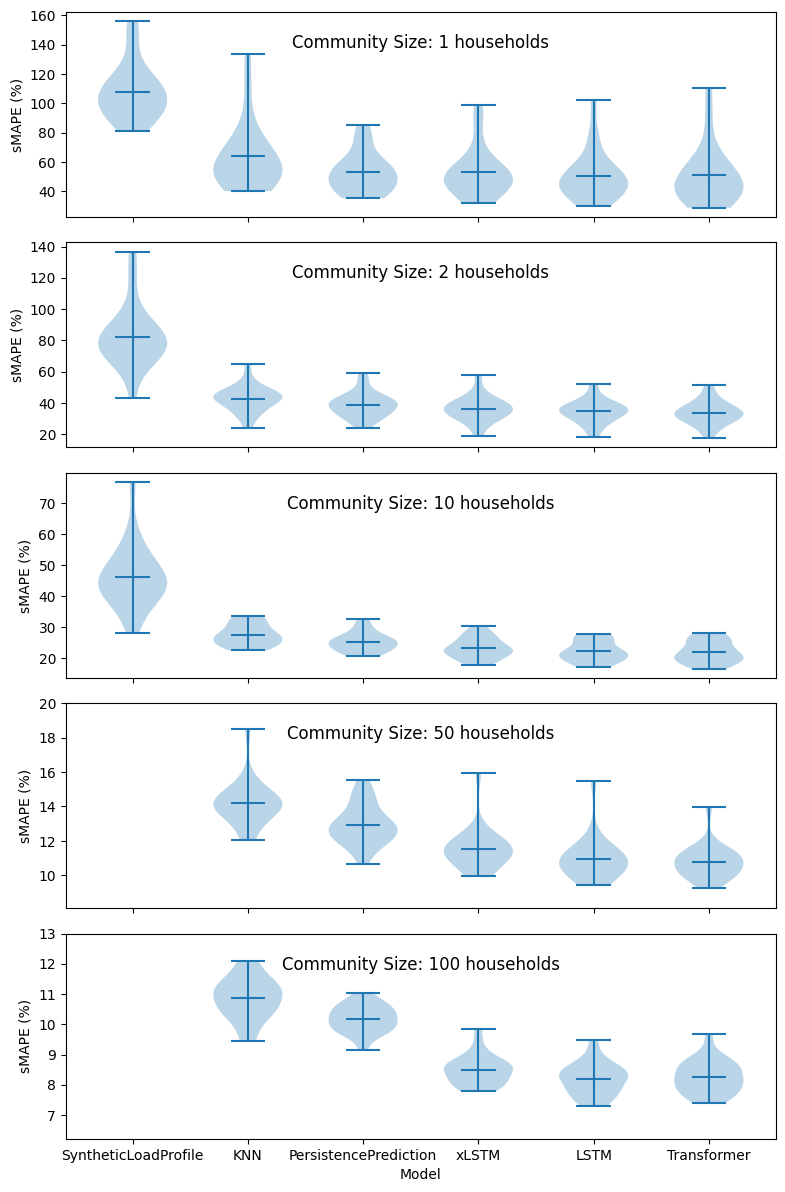

In [4]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)
result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

configs = [
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    ]

# Constants and Configuration
models = configs[0].usedModels
household_sizes = ['1', '2', '10', '50', '100']

# Helper function to retrieve full dataset for each configuration and model
def get_full_data_list(model, expected_configs, available_configs):
    myList = []
    for expected_config in expected_configs:
        for available_config in available_configs:
            if expected_config == available_config:            
                myList.append(result_dict[available_config][model])
    
    assert len(myList) == len(expected_configs), f"Not all configs found: {len(myList)} != {len(expected_configs)}."
    
    return myList

# Prepare data for each model
full_data_list = {model: get_full_data_list(model, configs, result_dict) for model in models}

# Transpose data for each household size
data_by_household_size = {}
for i, size in enumerate(household_sizes):
    data_by_household_size[size] = [full_data_list[model][i] for model in models]

# Creating subplots for each household size
fig, axes = plt.subplots(len(household_sizes), 1, figsize=(8, 12), sharex=True, sharey=False)

# Plot each household size's data on a separate subplot
for idx, (size, data) in enumerate(data_by_household_size.items()):
    ax = axes[idx]
    
    # Plot violin plot
    positions = np.array(range(len(models)))
    violins = ax.violinplot(data, positions=positions, widths=0.6, 
                            showmeans=True, showextrema=True, showmedians=False)
    
    # Labels and title
    ax.set_ylabel('sMAPE (%)')
    ax.text(0.5, 0.85, f"Community Size: {size} households", transform=ax.transAxes, fontsize=12, ha="center", va="center")
    ax.set_xticks(positions)
    ax.set_xticklabels(models)
    
    # Set x-axis label for the last plot
    if idx == len(household_sizes) - 1:
        ax.set_xlabel('Model')

axes[0].set_ylim(None, None)
axes[1].set_ylim(None, None)
axes[2].set_ylim(None, None)
axes[3].set_ylim(None, 20)
axes[4].set_ylim(None, 13)
plt.tight_layout()
plt.savefig("scripts/outputs/figs/error_over_community_size.pdf", format="pdf", bbox_inches="tight", pad_inches=0.1)
plt.show()


In [19]:
# Compare with and without transfer learning of the given configurations 
#

# Get specific results
#
importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

result_dict = utils.Evaluate_Models.print_results('scripts/outputs/all_train_histories.pkl', 
                                    print_style = 'pandas_df')

printed_configs = [

    # Vary the model sizes
    Config_of_one_run(ModelSize.SMALL, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.LARGE, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),

    # Vary the community sizes
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),

   # Vary the train set size
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._2_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._4_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._15_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    
    # Vary the input history size
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._6_DAYS, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._20_DAYS, UsedModels.ALL, Epochs.DEFAULT),
    
    # Without transfer learning:
    #
    
    # Vary the model sizes
    Config_of_one_run(ModelSize.SMALL, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.LARGE, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),

    # Vary the community sizes
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._1_HOUSEHOLD, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._2_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._10_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._100_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    
    # Vary the train set size
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._2_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._4_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._6_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._9_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._15_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    
    # Vary the input history size
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._6_DAYS, UsedModels.ALL, Epochs.DEFAULT),
    Config_of_one_run(ModelSize.MEDIUM, DoPretraining.NO, DoTransferLearning.NO, Aggregation_Count._50_HOUSEHOLDS, NrOfComunities._20, 
            TrainingHistory._12_MONTH, ModelInputHistory._20_DAYS, UsedModels.ALL, Epochs.DEFAULT),
]

# Constants and Configuration
config_names = ['Small', 'Medium (Baseline)', 'Large', 
                '1', '2', '10', '50 (Baseline)', '100',
                '2 mo', '4 mo', '6 mo', '9 mo', '12 mo (Baseline)', '15 mo',
                '2 days (Baseline)', '7 days', '21 days',
                ]
config_groups = [('Model Size', 3), '-', '-', 
                ('Aggregation', 4), '-', '-', '-', '-',
                ('Training Size', 4), '-', '-', '-', '-', '-',
                ('Input Seq Length', 3), '-', '-',
                ]
configs_with_transfer_learning = printed_configs[:len(config_names)]
configs_without_transfer_learning = printed_configs[len(config_names):]

assert len(config_names) == len(config_groups) == len(configs_with_transfer_learning) == len(configs_without_transfer_learning), \
        f"Unexpected list length: {len(configs)} != {len(config_names)} != {len(configs_with_transfer_learning)} != {len(configs_without_transfer_learning)}"


utils.Evaluate_Models.print_latex_table(result_dict, configs_with_transfer_learning, config_groups, config_names)
utils.Evaluate_Models.print_latex_table(result_dict, configs_without_transfer_learning, config_groups, config_names)


\hline
\multirow{3}{*}{\textbf{Model Size}} 
    & Small & 27.24 (2.52) & 14.23 (1.29) & 12.95 (1.15) & 11.36 (1.22) & \textbf{10.77} (1.20) & 10.82 (1.03) \\ 
    & Medium (Baseline) & 27.24 (2.52) & 14.23 (1.29) & 12.95 (1.15) & 11.54 (1.23) & 10.98 (1.27) & \textbf{10.78} (0.97) \\ 
    & Large & 27.24 (2.52) & 14.23 (1.29) & 12.95 (1.15) & 11.74 (1.38) & 11.15 (1.33) & \textbf{10.79} (1.00) \\ 
\hline
\multirow{4}{*}{\textbf{Aggregation}} 
    & 1 & 107.99 (18.67) & 63.86 (22.69) & 52.91 (13.53) & 53.04 (16.37) & \textbf{50.75} (16.66) & 50.83 (19.52) \\ 
    & 2 & 82.29 (19.52) & 42.78 (8.52) & 38.80 (7.91) & 36.24 (8.01) & 34.56 (7.42) & \textbf{33.62} (7.46) \\ 
    & 10 & 46.25 (10.09) & 27.49 (3.40) & 25.17 (3.08) & 23.21 (3.31) & 22.15 (3.29) & \textbf{21.88} (3.49) \\ 
    & 50 (Baseline) & 27.24 (2.52) & 14.23 (1.29) & 12.95 (1.15) & 11.54 (1.23) & 10.98 (1.27) & \textbf{10.78} (0.97) \\ 
    & 100 & 25.89 (1.78) & 10.87 (0.68) & 10.18 (0.44) & 8.48 (0.49) & \textbf{8.18} (

torch.Size([20, 131])
2013-10-20 00:00:00+00:00
torch.Size([20, 131])


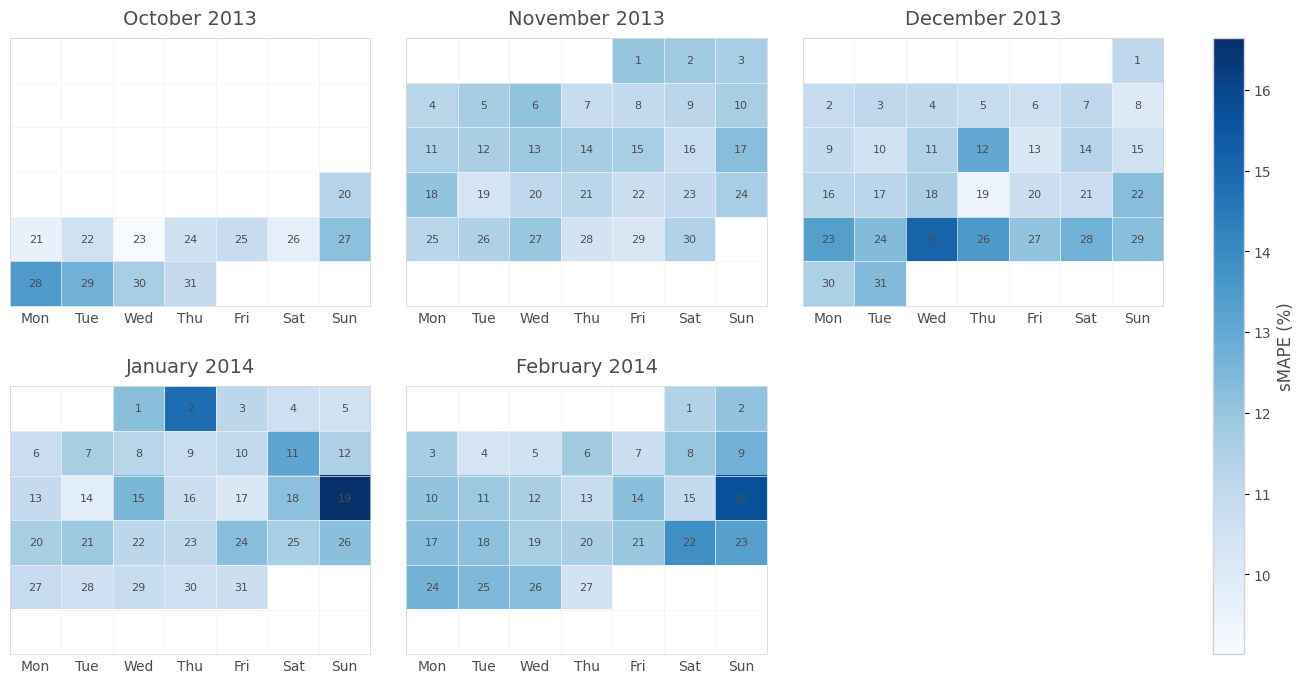

In [ ]:
# Create Calendar Plot
#

importlib.reload(Model)
importlib.reload(Simulation_config)
importlib.reload(utils)
importlib.reload(ModelTrainer)

# Get specific results
#
path_to_trained_parameters = 'scripts/outputs/all_trained_models.pth'
myConfig = Config_of_one_run(ModelSize.MEDIUM, DoPretraining.YES, DoTransferLearning.YES, Aggregation_Count._50_HOUSEHOLDS, 
                NrOfComunities._20, TrainingHistory._12_MONTH, ModelInputHistory._1_DAY, UsedModels.ALL, Epochs.DEFAULT)
model_type = 'xLSTM'

modelTrainer = ModelTrainer.ModelTrainer()
loadProfiles, weatherData, public_holidays_timestamps = modelTrainer.load_data(myConfig)
modelAdapter = ModelAdapter.ModelAdapter(public_holidays_timestamps,
                        train_size = myConfig.trainingHistory,
                        test_size = modelTrainer.test_set_size_days,
                        prediction_history = myConfig.modelInputHistory,
                        )

# Do Predictions
#
smape_values = None
for community_id in range(Simulation_config.NrOfComunities._20):
    X, Y = modelAdapter.transformData(loadProfiles[community_id], weatherData)
    P_el_predicted = modelAdapter.deNormalizeY(Y['test']).flatten().unsqueeze(0)
    test_profile = f"scripts/outputs/file_{community_id}.pkl"
    num_of_features = X['test'].shape[2]
    my_Model = utils.Deserialize.get_trained_model(path_to_trained_parameters, model_type, test_profile, myConfig, num_of_features)
    Y_pred = modelAdapter.deNormalizeY(my_Model.predict(X['test'], Y['test'])).squeeze()
    Y_real = modelAdapter.deNormalizeY(Y['test']).squeeze()
    smape = my_Model.smape(Y_pred, Y_real, dim=1).unsqueeze(0)
    if smape_values == None:
        smape_values = torch.zeros((0, Y_pred.shape[0]))
    smape_values = torch.cat([smape_values, smape], dim=0)
        
startdate = modelAdapter.getStartDateFromIndex('test', 0)
print(f"startdate = {startdate}")

# Print daily sMAPE results of chosen community
#
community_id = 0
test_day_nrs = [3, 91]
for test_day_nr in test_day_nrs:
    print(f"sMAPE = {smape_values[community_id, test_day_nr].item():.1f}% " \
          f"of community {community_id} on test day {test_day_nr}.")
    
# Average over the different commnities
#
daily_values = smape_values.mean(dim=0) 
print(smape_values.shape)

# Create plot
#
utils.Evaluate_Models.create_calendar_plot(startdate, daily_values)
